In [17]:
import string
import numpy as np
import pandas as pd
import nltk
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from HappyFunTokenizer import HappyFunTokenizer
from sklearn_pandas import DataFrameMapper
import os 
import spacy

# Preprocessing

In [146]:
def get_rel_path(file_name):
    absolutepath = os.path.abspath('')
    #print(absolutepath)
    fileDirectory = os.path.dirname(absolutepath)
    file_path = os.path.join(fileDirectory, 'Data/' + str(file_name))   
    #print(file_path)
    return file_path

In [18]:
# load files
# read in files from folder 
folder_path = get_rel_path("/review_polarity/txt_sentoken/neg")
neg_reviews = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        with open(os.path.join(root, file), 'r') as f:
            text = f.read()
            neg_reviews.append(text)

folder_path = get_rel_path("/review_polarity/txt_sentoken/pos")
pos_reviews = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        with open(os.path.join(root, file), 'r') as f:
            text = f.read()
            pos_reviews.append(text)

all_reviews = [neg_reviews, pos_reviews]


# Feature: negation 

In [19]:
# Sentiment aware tokenization + negation 
neg_reviews_tokens = []
pos_reviews_tokens = []
tokenizer = HappyFunTokenizer()
        
for review in neg_reviews:
    tokens = tokenizer.tokenize(review, negation = True)
    neg_reviews_tokens.append(tokens)

for review in pos_reviews:
    tokens = tokenizer.tokenize(review, negation = True)
    pos_reviews_tokens.append(tokens)

print(len(neg_reviews_tokens))
print(len(pos_reviews_tokens))
all_reviews_tokens = pos_reviews_tokens + neg_reviews_tokens
print(len(all_reviews_tokens))

1000
1000
2000


In [20]:
# make dataframe 
sentiment = ([1] * 1000) + ([0] * 1000) # sentiment labels 
data = {'Sentiment': sentiment, 'Review': all_reviews_tokens}
df_data = pd.DataFrame(data)
df_data.describe()

,Sentiment
count,2000.000000
mean,0.500000
std,0.500125
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [24]:
def dummy_fun(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    min_df=2, 
    #max_df = 0.8, 
    use_idf =True,
    smooth_idf=True,
    sublinear_tf = True,
    )

In [25]:
tfidf_reviews = tfidf_vectorizer.fit_transform(df_data.loc[:, 'Review'])
print("n_samples: %d, n_features: %d" % tfidf_reviews.shape)
tfidf_reviews

n_samples: 2000, n_features: 28000


<2000x28000 sparse matrix of type '<class 'numpy.float64'>'
	with 685711 stored elements in Compressed Sparse Row format>

In [26]:
df_features = pd.DataFrame(tfidf_reviews.toarray())
df_features["Sentiment"] = df_data["Sentiment"]
df_features

,0,1,2,3,4,5,6,7,8,9,...,27991,27992,27993,27994,27995,27996,27997,27998,27999,Sentiment
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033641,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.049531,0.071770,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.072352,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.107190,0.059275,0.000000,0.0,0.070062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.064270,0.000000,0.0,0.066178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.000000,0.077298,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1996,0.0,0.0,0.0,0.0,0.0,0.013905,0.041603,0.000000,0.0,0.022647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1997,0.0,0.0,0.0,0.0,0.0,0.057822,0.040567,0.061128,0.0,0.066818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1998,0.0,0.0,0.0,0.0,0.0,0.031079,0.026267,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Feature: Pos/neg word ratio

In [27]:
def get_posneg_ratio(df):
    # import sentiment lexicon from csv 
    folder_path = get_rel_path('sentiment_lexicon.csv')
    sentiment_lex = pd.read_csv(file_path)
    # convert dataframe to dictionary for faster lookup 
    sentiment_lex = sentiment_lex.set_index('Word').T.to_dict("list") 
    ratios = []

    for index in range(len(df)):
        neg_count, pos_count = 0, 0
        neg = False 
        #tokens = df.loc[index, 'Review'].split()
        for token in df.loc[index, 'Review']:
            if "_NEG" in token: 
                token = token.replace("_NEG", "")
                neg = True
            sentiment = sentiment_lex.get(token)
            if sentiment == None:
                pos_count = pos_count
                neg_count = neg_count
                continue
            elif sentiment[0] == 1: #POS = 1
                if neg is True: neg_count = neg_count +1
                else: pos_count = pos_count +1
            elif sentiment[0] == 0: #NEG = 0
                if neg is True: pos_count = pos_count +1
                else: neg_count = neg_count +1
        if neg_count == 0: ratios.append(None)
        else:
            ratios.append(pos_count / neg_count)
    
    return ratios 

In [145]:
ratios = np.array(get_posneg_ratio(df_data), dtype=np.float64)
print("Sum", np.nansum(ratios), "Mean", np.nanmean(ratios))
df_features['Pos:Neg Ratio'] = ratios 
df_features

Sum 2931.746928602811 Mean 1.4658734643014055


,0,1,2,3,4,5,6,7,8,9,...,27994,27995,27996,27997,27998,27999,Sentiment,Pos:Neg Ratio,Length,Noun Phrases
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033641,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.098361,1016,251
1,0.0,0.0,0.0,0.0,0.0,0.049531,0.071770,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.323077,569,128
2,0.0,0.0,0.0,0.0,0.0,0.072352,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,8.000000,262,74
3,0.0,0.0,0.0,0.0,0.0,0.107190,0.059275,0.000000,0.0,0.070062,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.524272,677,175
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.064270,0.000000,0.0,0.066178,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.200000,627,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.000000,0.077298,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.392405,555,125
1996,0.0,0.0,0.0,0.0,0.0,0.013905,0.041603,0.000000,0.0,0.022647,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.498559,1967,466
1997,0.0,0.0,0.0,0.0,0.0,0.057822,0.040567,0.061128,0.0,0.066818,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.721739,780,173
1998,0.0,0.0,0.0,0.0,0.0,0.031079,0.026267,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.231076,1252,333


<AxesSubplot:xlabel='Pos:Neg Ratio', ylabel='Count'>

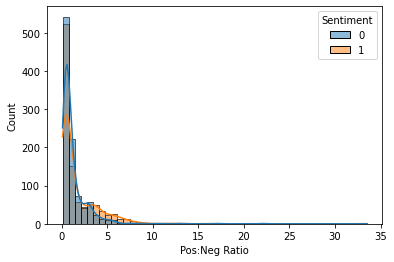

In [32]:
import seaborn as sns
sns.histplot(data = df_features, x = 'Pos:Neg Ratio', bins = 50, kde = True, hue = 'Sentiment')

# Feature: Text Length 

In [33]:
def get_length(df):
    review_size = []
    for index in range(len(df)):
        review = df.loc[index, 'Review']
        review_size.append(len(review))
 
    return review_size

In [36]:
length = np.array(get_length(df_data))
print("Sum", np.sum(length), " Mean", np.mean(length))
df_features["Length"] = length
df_features

Sum 1499248  Mean 749.624


,0,1,2,3,4,5,6,7,8,9,...,27995,27996,27997,27998,27999,Sentiment,Pos:Neg Ratio,Pos:Neg Ratio scaled,Length,Length scaled
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033641,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,1.098361,-0.190939,1016,0.808520
1,0.0,0.0,0.0,0.0,0.0,0.049531,0.071770,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,1.323077,-0.074189,569,-0.548240
2,0.0,0.0,0.0,0.0,0.0,0.072352,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1,8.000000,3.394759,262,-1.480065
3,0.0,0.0,0.0,0.0,0.0,0.107190,0.059275,0.000000,0.0,0.070062,...,0.0,0.0,0.0,0.0,0.0,0,0.524272,-0.489202,677,-0.220433
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.064270,0.000000,0.0,0.066178,...,0.0,0.0,0.0,0.0,0.0,1,0.200000,-0.657676,627,-0.372195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.000000,0.077298,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,0.392405,-0.557713,555,-0.590734
1996,0.0,0.0,0.0,0.0,0.0,0.013905,0.041603,0.000000,0.0,0.022647,...,0.0,0.0,0.0,0.0,0.0,1,0.498559,-0.502561,1967,3.695050
1997,0.0,0.0,0.0,0.0,0.0,0.057822,0.040567,0.061128,0.0,0.066818,...,0.0,0.0,0.0,0.0,0.0,0,0.721739,-0.386610,780,0.092199
1998,0.0,0.0,0.0,0.0,0.0,0.031079,0.026267,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1,0.231076,-0.641530,1252,1.524841


Length: raw counts


<AxesSubplot:xlabel='Length', ylabel='Count'>

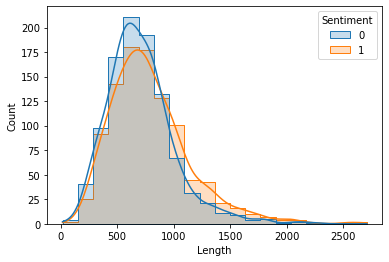

In [35]:
print("Length: raw counts")
sns.histplot(data = df_features, x = 'Length',bins = 20, kde = True, hue = 'Sentiment', element = 'step')

# Dependency parsing: Noun Phrases 

In [118]:
from spacy.symbols import ADJ, VERB, NOUN
from nltk.tokenize import sent_tokenize

In [89]:
nlp = spacy.load("en_core_web_sm")
reviews = df_data["Review"].values
noun_chunks = [] 
for review in reviews:
    r = " ".join(review)
    r = r.replace("_NEG", "")
    sentences = sent_tokenize(r)
    chunk_count = 0
    #print("-------new review")
    for sentence in sentences:
        #print("--new sentence")
        doc = nlp(sentence)
        chunks = doc.noun_chunks
        for chunk in chunks: chunk_count = chunk_count + 1
    noun_chunks.append(chunk_count)

<AxesSubplot:xlabel='Noun Phrases', ylabel='Count'>

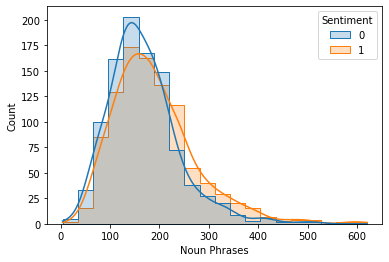

In [94]:
df["Noun Phrases"] = noun_chunks
sns.histplot(data = df_features, x = 'Noun Phrases',bins = 20, kde = True, hue = 'Sentiment', element = 'step')

In [138]:
df_features

,0,1,2,3,4,5,6,7,8,9,...,27994,27995,27996,27997,27998,27999,Sentiment,Pos:Neg Ratio,Length,Noun Phrases
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033641,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.098361,1016,251
1,0.0,0.0,0.0,0.0,0.0,0.049531,0.071770,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.323077,569,128
2,0.0,0.0,0.0,0.0,0.0,0.072352,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,8.000000,262,74
3,0.0,0.0,0.0,0.0,0.0,0.107190,0.059275,0.000000,0.0,0.070062,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.524272,677,175
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.064270,0.000000,0.0,0.066178,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.200000,627,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.000000,0.077298,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.392405,555,125
1996,0.0,0.0,0.0,0.0,0.0,0.013905,0.041603,0.000000,0.0,0.022647,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.498559,1967,466
1997,0.0,0.0,0.0,0.0,0.0,0.057822,0.040567,0.061128,0.0,0.066818,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.721739,780,173
1998,0.0,0.0,0.0,0.0,0.0,0.031079,0.026267,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.231076,1252,333


# Export to csv 

In [140]:
folder_path = get_rel_path("data.csv")
df_features.to_csv(folder_path, index = False)